In [1]:
!pip install PyWavelets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 16.9 MB/s eta 0:00:00


<ipython-input-5-fc5d9ccb62fc>:80: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  return psnr(original, denoised)


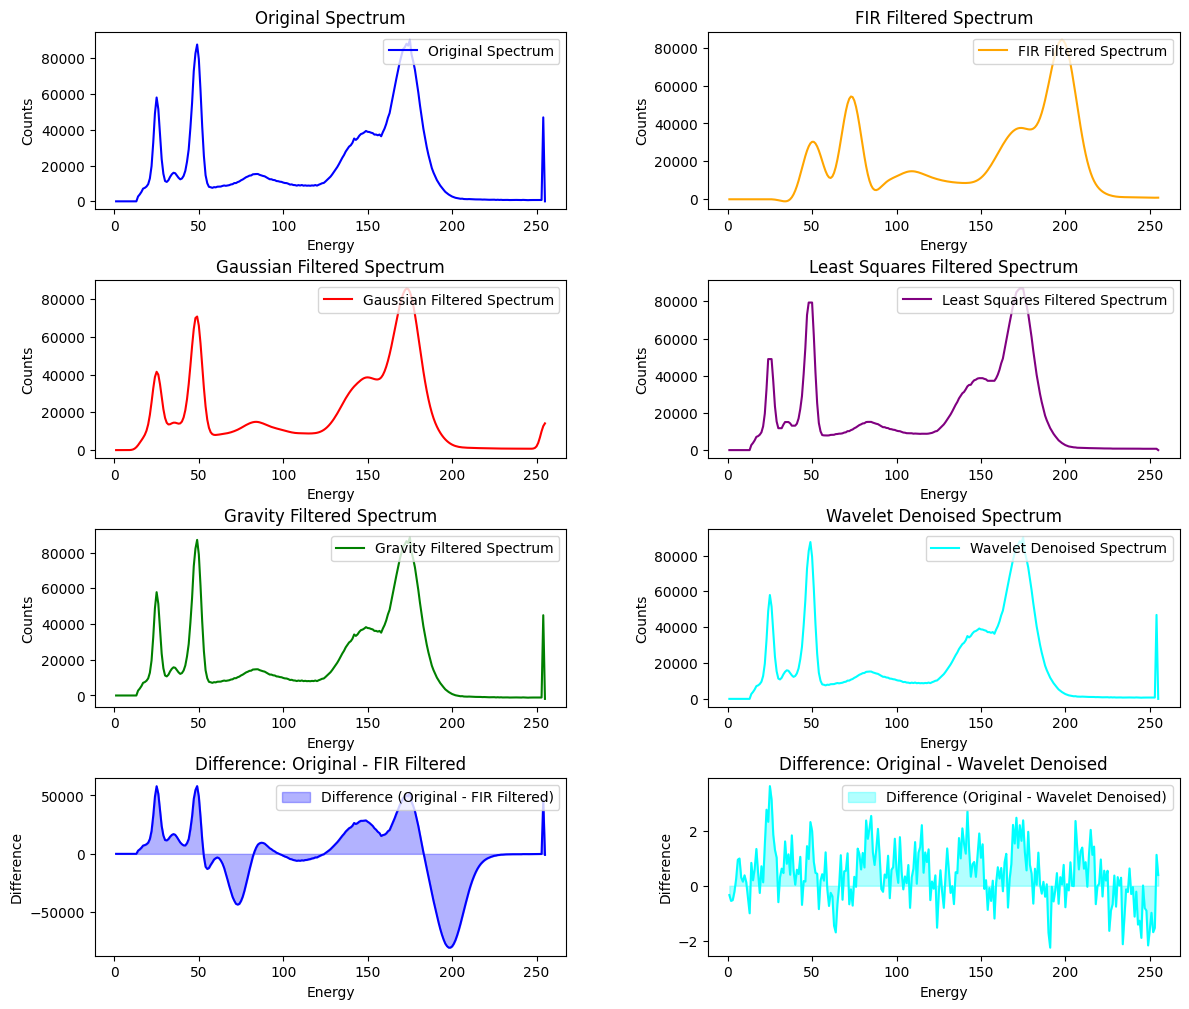

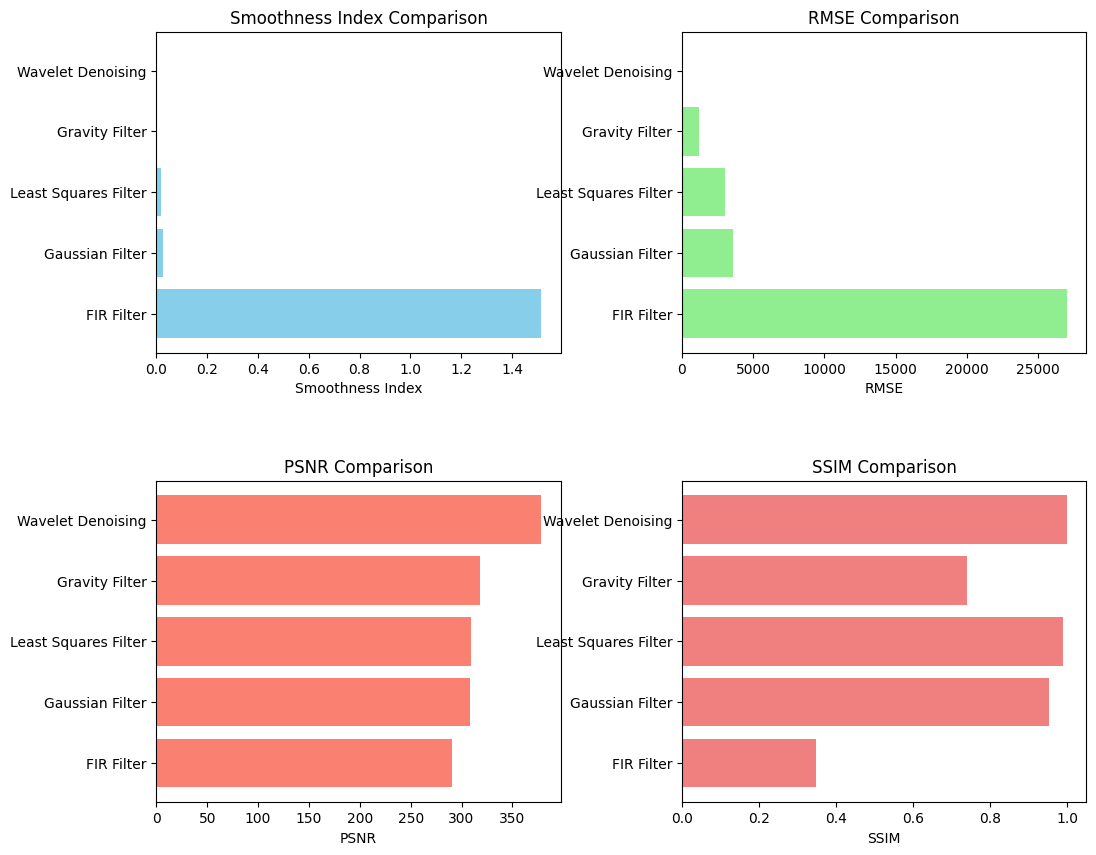

In [5]:
import numpy as np
import pandas as pd
from scipy import signal
import pywt
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from scipy.ndimage import gaussian_filter

# 1. Read data from the CSV file
filename = '15.5.csv'
data = pd.read_csv(filename)

# Assuming the columns are named 'energy' and 'counts' in your CSV
energy = data.iloc[:, 0].values
spectrum = data.iloc[:, 1].values  # Use 'counts' as the intensity

# 2. Denoising methods

# 2.1 FIR Convolution Filtering
def fir_filter(signal_data, cutoff, fs, order=30):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b = signal.firwin(order + 1, normal_cutoff, window='hamming')
    filtered_signal = signal.lfilter(b, 1.0, signal_data)
    return filtered_signal

def gaussian_filter_custom(signal_data, sigma=2):
    """Gaussian Filter for smoothing"""
    return gaussian_filter(signal_data, sigma=sigma)

def least_squares_filter(signal_data, window_size=5):
    """Least Squares Filter for smoothing"""
    return signal.medfilt(signal_data, window_size)

def gravity_filter(signal_data, alpha=0.1):
    """Gravity Filter for smoothing"""
    return signal_data - alpha * np.cumsum(signal_data) / len(signal_data)

# FIR filter parameters
cutoff = 0.05  # Lower cutoff frequency for better noise reduction
fs = 1.0       # Sampling frequency (Hz)
order = 50     # Increased filter order for a more accurate filter

filtered_signal_fir = fir_filter(spectrum, cutoff, fs, order)

# Applying additional FIR methods
filtered_signal_gaussian = gaussian_filter_custom(spectrum)
filtered_signal_least_squares = least_squares_filter(spectrum)
filtered_signal_gravity = gravity_filter(spectrum)

# 2.2 Wavelet Denoising
def wavelet_denoising(signal_data, wavelet='db4', level=5):
    coeffs = pywt.wavedec(signal_data, wavelet, level=level)
    threshold = np.sqrt(2 * np.log(len(signal_data))) * (1/np.sqrt(2**np.arange(level+1)))
    coeffs_thresholded = [pywt.threshold(c, value=t, mode='soft') for c, t in zip(coeffs, threshold)]
    reconstructed_signal = pywt.waverec(coeffs_thresholded, wavelet)

    # Adjust the length to match the original signal
    if len(reconstructed_signal) > len(signal_data):
        reconstructed_signal = reconstructed_signal[:len(signal_data)]
    elif len(reconstructed_signal) < len(signal_data):
        reconstructed_signal = np.pad(reconstructed_signal, (0, len(signal_data) - len(reconstructed_signal)), mode='constant')

    return reconstructed_signal

denoised_signal_wavelet = wavelet_denoising(spectrum)

# 3. Evaluation Metrics

def smoothness_index(original, denoised):
    variance_original = np.var(original)
    variance_diff = np.var(original - denoised)
    return variance_diff / variance_original

def rmse(original, denoised):
    return np.sqrt(np.mean((original - denoised) ** 2))

def calculate_psnr(original, denoised):
    return psnr(original, denoised)

def calculate_ssim(original, denoised):
    # Ensure both signals are of the same length for SSIM calculation
    min_length = min(len(original), len(denoised))
    return ssim(original[:min_length], denoised[:min_length], data_range=np.max(original) - np.min(original))

# Calculate values for all methods
smoothness_fir = smoothness_index(spectrum, filtered_signal_fir)
smoothness_gaussian = smoothness_index(spectrum, filtered_signal_gaussian)
smoothness_least_squares = smoothness_index(spectrum, filtered_signal_least_squares)
smoothness_gravity = smoothness_index(spectrum, filtered_signal_gravity)
smoothness_wavelet = smoothness_index(spectrum, denoised_signal_wavelet)

rmse_fir = rmse(spectrum, filtered_signal_fir)
rmse_gaussian = rmse(spectrum, filtered_signal_gaussian)
rmse_least_squares = rmse(spectrum, filtered_signal_least_squares)
rmse_gravity = rmse(spectrum, filtered_signal_gravity)
rmse_wavelet = rmse(spectrum, denoised_signal_wavelet)

psnr_fir = calculate_psnr(spectrum, filtered_signal_fir)
psnr_gaussian = calculate_psnr(spectrum, filtered_signal_gaussian)
psnr_least_squares = calculate_psnr(spectrum, filtered_signal_least_squares)
psnr_gravity = calculate_psnr(spectrum, filtered_signal_gravity)
psnr_wavelet = calculate_psnr(spectrum, denoised_signal_wavelet)

ssim_fir = calculate_ssim(spectrum, filtered_signal_fir)
ssim_gaussian = calculate_ssim(spectrum, filtered_signal_gaussian)
ssim_least_squares = calculate_ssim(spectrum, filtered_signal_least_squares)
ssim_gravity = calculate_ssim(spectrum, filtered_signal_gravity)
ssim_wavelet = calculate_ssim(spectrum, denoised_signal_wavelet)



# Plotting the results
plt.figure(figsize=(14, 12))  # Adjusted figure size

# Plot Original Spectrum and Denoised Signals
plt.subplot(4, 2, 1)
plt.plot(energy, spectrum, label='Original Spectrum', color='blue', linewidth=1.5)
plt.title('Original Spectrum')
plt.xlabel('Energy')
plt.ylabel('Counts')
plt.legend(loc='upper right')

plt.subplot(4, 2, 2)
plt.plot(energy, filtered_signal_fir, label='FIR Filtered Spectrum', color='orange', linewidth=1.5)
plt.title('FIR Filtered Spectrum')
plt.xlabel('Energy')
plt.ylabel('Counts')
plt.legend(loc='upper right')

plt.subplot(4, 2, 3)
plt.plot(energy, filtered_signal_gaussian, label='Gaussian Filtered Spectrum', color='red', linewidth=1.5)
plt.title('Gaussian Filtered Spectrum')
plt.xlabel('Energy')
plt.ylabel('Counts')
plt.legend(loc='upper right')

plt.subplot(4, 2, 4)
plt.plot(energy, filtered_signal_least_squares, label='Least Squares Filtered Spectrum', color='purple', linewidth=1.5)
plt.title('Least Squares Filtered Spectrum')
plt.xlabel('Energy')
plt.ylabel('Counts')
plt.legend(loc='upper right')

plt.subplot(4, 2, 5)
plt.plot(energy, filtered_signal_gravity, label='Gravity Filtered Spectrum', color='green', linewidth=1.5)
plt.title('Gravity Filtered Spectrum')
plt.xlabel('Energy')
plt.ylabel('Counts')
plt.legend(loc='upper right')

plt.subplot(4, 2, 6)
plt.plot(energy, denoised_signal_wavelet, label='Wavelet Denoised Spectrum', color='cyan', linewidth=1.5)
plt.title('Wavelet Denoised Spectrum')
plt.xlabel('Energy')
plt.ylabel('Counts')
plt.legend(loc='upper right')

# Plot Differences
plt.subplot(4, 2, 7)
plt.fill_between(energy, spectrum - filtered_signal_fir, color='blue', alpha=0.3, label='Difference (Original - FIR Filtered)')
plt.plot(energy, spectrum - filtered_signal_fir, color='blue', linewidth=1.5)
plt.title('Difference: Original - FIR Filtered')
plt.xlabel('Energy')
plt.ylabel('Difference')
plt.legend(loc='upper right')

plt.subplot(4, 2, 8)
plt.fill_between(energy, spectrum - denoised_signal_wavelet, color='cyan', alpha=0.3, label='Difference (Original - Wavelet Denoised)')
plt.plot(energy, spectrum - denoised_signal_wavelet, color='cyan', linewidth=1.5)
plt.title('Difference: Original - Wavelet Denoised')
plt.xlabel('Energy')
plt.ylabel('Difference')
plt.legend(loc='upper right')

plt.subplots_adjust(hspace=0.4, wspace=0.3)  # Adjusted spacing

# Plot Comparison Metrics
plt.figure(figsize=(12, 10))  # Adjusted figure size

# Smoothness Index Comparison
plt.subplot(2, 2, 1)
methods = ['FIR Filter', 'Gaussian Filter', 'Least Squares Filter', 'Gravity Filter', 'Wavelet Denoising']
smoothness_values = [smoothness_fir, smoothness_gaussian, smoothness_least_squares, smoothness_gravity, smoothness_wavelet]
plt.barh(methods, smoothness_values, color='skyblue')
plt.title('Smoothness Index Comparison')
plt.xlabel('Smoothness Index')

# RMSE Comparison
plt.subplot(2, 2, 2)
rmse_values = [rmse_fir, rmse_gaussian, rmse_least_squares, rmse_gravity, rmse_wavelet]
plt.barh(methods, rmse_values, color='lightgreen')
plt.title('RMSE Comparison')
plt.xlabel('RMSE')

# PSNR Comparison
plt.subplot(2, 2, 3)
psnr_values = [psnr_fir, psnr_gaussian, psnr_least_squares, psnr_gravity, psnr_wavelet]
plt.barh(methods, psnr_values, color='salmon')
plt.title('PSNR Comparison')
plt.xlabel('PSNR')

# SSIM Comparison
plt.subplot(2, 2, 4)
ssim_values = [ssim_fir, ssim_gaussian, ssim_least_squares, ssim_gravity, ssim_wavelet]
plt.barh(methods, ssim_values, color='lightcoral')
plt.title('SSIM Comparison')
plt.xlabel('SSIM')

plt.subplots_adjust(hspace=0.4, wspace=0.3)  # Adjusted spacing

# Show all plots
plt.show()
